In [4]:
#!pip install graphlearning
from ot_class import *

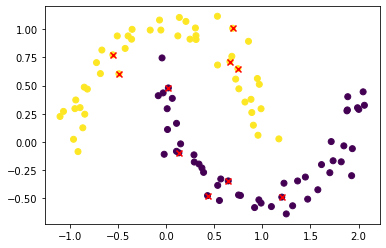

In [5]:
#print(u)

predictions = predict(u)
plt.scatter(X[:,0],X[:,1], c=predictions)
plt.scatter(X[labeled_ind, 0], X[labeled_ind, 1], marker = 'x', c = 'red')

In [7]:
save_models(u, "wass1_data.pickle")

In [3]:
model = gl.ssl.poisson(W, solver='gradient_descent')
poisson_u = model.fit(labeled_ind, labels[labeled_ind])
print(norm(u - poisson_u))

196.72823121272063


In [23]:
print(1- predictions - model.predict())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
